## Exploring pytorch models and BTC predictions

from: https://www.kaggle.com/datasets/novandraanugrah/bitcoin-historical-datasets-2018-2024?resource=download

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

In [2]:
df_daily = pd.read_csv("../data/bitcoin-historical-datasets/btc_1d_data_2018_to_2025.csv")
df_daily['Open time'] = pd.to_datetime(df_daily['Open time'])



In [3]:
df_daily['day_index'] = df_daily['Open time'].apply(lambda x: (x - df_daily['Open time'].min()).days )

In [4]:

df_daily = df_daily.set_index('day_index')

In [84]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class BitcoinSimpleDataset(Dataset):
    def __init__(self, df):
        """
        Args:
            df (pd.DataFrame): DataFrame with integer index as day number and 'Open' price column.
        """
        self.data = np.log(df[['Open']].values.astype('float32'))  # Extract 'Open' prices
        self.index = df.index.values.astype('float32')  # Extract day indices

        # Normalize day index (0 to 1)
        self.data -= self.data.min()
        self.data /= self.data.max()
        self.index = self.index / self.index.max() if self.index.max() > 0 else self.index

        # Reshape the input to (-1, 1) here, so it's ready for the model
        self.index = self.index.reshape(-1, 1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve
        """
        # Return a tuple of (input, target)
        input_data = torch.tensor(self.index[idx], dtype=torch.float32)  # Input (normalized day index)
        target_data = torch.tensor(self.data[idx], dtype=torch.float32)  # Output (log-transformed 'Open' price)
        
        return input_data, target_data

    def old__getitem__(self, idx):
        # Get price sequence
        x_prices = self.data[idx : idx + self.seq_length]
        # Get normalized day indices for same sequence
        x_time = self.index[idx : idx + self.seq_length].reshape(-1, 1)
        # Target price (next day)
        y = self.data[idx + self.seq_length]

        # Stack features: (seq_length, 2) -> [ [day, price], ... ]
        x = np.hstack([x_time]) #, x_prices]) 

        return torch.tensor(x), torch.tensor(y)


In [85]:

# Create dataset and DataLoader
dataset = BitcoinSimpleDataset(df_daily)
dataloader = DataLoader(dataset, batch_size=df_daily.shape[0], shuffle=False)


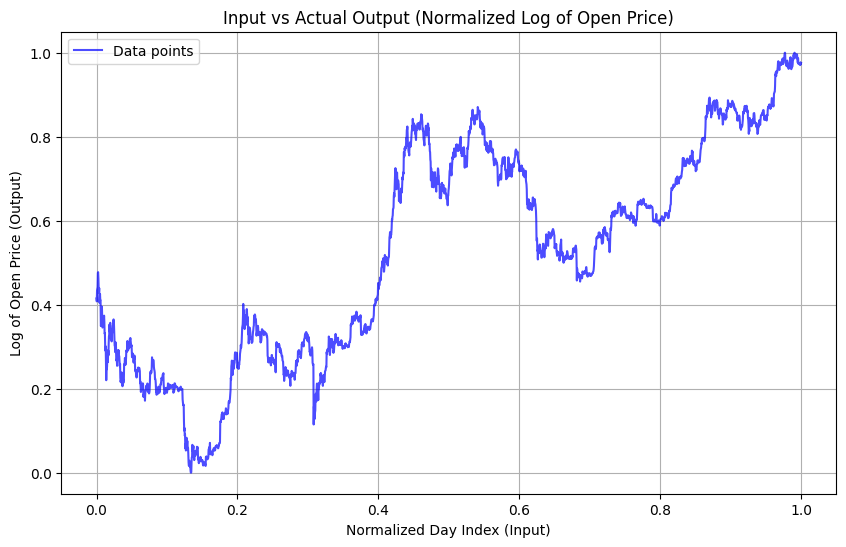

In [86]:
import matplotlib.pyplot as plt

# Extract the input and target values
inputs = []
targets = []

# Loop through the dataset and collect all inputs and targets
for i in range(len(dataset)):
    input_data, target_data = dataset[i]
    inputs.append(input_data.item())  # .item() converts tensor to Python scalar
    targets.append(target_data.item())

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(inputs, targets, label='Data points', color='blue', alpha=0.7)
plt.title('Input vs Actual Output (Normalized Log of Open Price)')
plt.xlabel('Normalized Day Index (Input)')
plt.ylabel('Log of Open Price (Output)')
plt.grid(True)
plt.legend()
plt.show()

## Define Model

In [87]:
from torch.autograd import Variable
import torch
import torch.optim as optim
import math
    
class SinCurveFitter(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(1, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.hidden3 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 1)
  
    def forward(self, x, return_hidden=False):
        x = torch.relu(self.hidden(x))
        x = torch.relu(self.hidden2(x))
        hidden = torch.relu(self.hidden3(x))
        x = self.output(hidden)
        if return_hidden:
            return x, hidden
        return x
    
class SimpleScaler(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.layer_1 = nn.Linear(1,hidden_size)
        self.layer_2 = nn.Linear(hidden_size,1)

    def forward(self, x):
        xx = torch.relu(self.layer_1(x))
        return self.layer_2(xx)
    
class LayeredScaler(nn.Module):
    def __init__(self, h1, h2):
        super().__init__()
        self.layer_1 = nn.Linear(1,h1)
        self.layer_2 = nn.Linear(h1,h2)
        self.layer_3 = nn.Linear(h2, 1, bias=True)

    def forward(self, x):
        v = torch.relu(self.layer_1(x))
        v = torch.relu(self.layer_2(v))
        v = self.layer_3(v)
        return v
    
class CycleOptimizer(nn.Module):
    def __init__(self):
        super().__init__()

        self.sub_model = SinCurveFitter()
        self.alpha = SimpleScaler(5)
        #self.beta = SimpleScaler(5)
        # take log here so we can take exp later to ensure value stays postive
        self.period_param = nn.Parameter(torch.tensor([math.log(0.25)])) 
        
    def forward(self, x):
        period = torch.exp(self.period_param)
        cycle_x = self.sub_model(x % period)
        return self.alpha(x) * cycle_x # + self.beta(x)
    

### Fit

In [102]:
model = SinCurveFitter().to('cpu')
#model = LayeredScaler(16,8)
#model = SimpleScaler(3)
#model = CycleOptimizer() # CycleOptimizerQuantile
print(model)


optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.00)

SinCurveFitter(
  (hidden): Linear(in_features=1, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (hidden3): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
)


In [103]:
def train_model(model, optimizer, dataloader, num_epochs=1000, loss_func=nn.MSELoss):
    # Loss function (MSE)
    criterion = loss_func() #nn.MSELoss()

    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, Y_batch in dataloader:
            #model.train()

            # Forward pass: get model predictions
            predictions = model(X_batch)
            
            # Compute the loss
            loss = criterion(predictions, Y_batch)

            # Backward pass: compute gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Print loss every 100 epochs
        if (epoch+1) % 100 == 0 or (epoch+1) == num_epochs:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.train()
train_model(model, optimizer, dataloader, num_epochs=1000)

Epoch [100/1000], Loss: 0.0075
Epoch [200/1000], Loss: 0.0047
Epoch [300/1000], Loss: 0.0025
Epoch [400/1000], Loss: 0.0023
Epoch [500/1000], Loss: 0.0022
Epoch [600/1000], Loss: 0.0021
Epoch [700/1000], Loss: 0.0016
Epoch [800/1000], Loss: 0.0026
Epoch [900/1000], Loss: 0.0019
Epoch [1000/1000], Loss: 0.0016


In [104]:
# Prediction phase (no gradient calculation)
model.eval()  # Set the model to evaluation mode

# Collect predictions
predictions = []
actuals = []
time_indices = []

with torch.no_grad():  # Disable gradients during inference
    for X_batch, Y_batch in dataloader:
        Y_pred = model(X_batch)  # Get predictions
        predictions.append(Y_pred.squeeze().numpy())  # Flatten and convert to NumPy
        actuals.append(Y_batch.numpy())  # Get actual values (Y)
        time_indices.append(X_batch[:, 0].numpy())  # Extract time indices (first feature in X_batch)

# Concatenate the predictions, actuals, and time indices
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)
time_indices = np.concatenate(time_indices)

In [105]:
df_pred = pd.DataFrame(np.array([time_indices, predictions, actuals.reshape(-1)]).T, columns=['time', 'predicted', 'actual'])

In [106]:
df_pred.sort_values('time', inplace=True)

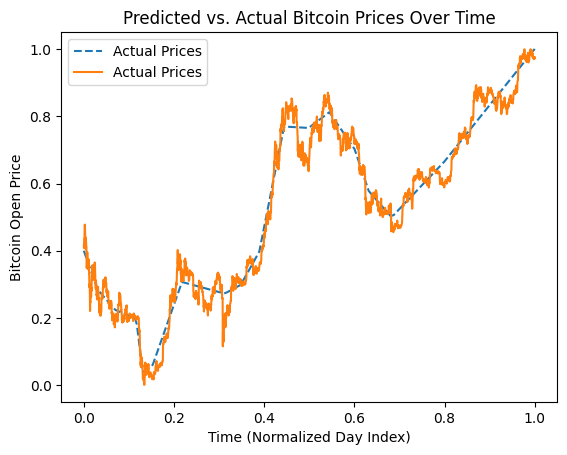

In [107]:
# Plot the results
#plt.plot(time_indices, predictions, label="Predicted Prices", linestyle="dashed")
plt.plot(df_pred['time'], df_pred['predicted'], label="Actual Prices", linestyle="dashed")
plt.plot(df_pred['time'], df_pred['actual'], label="Actual Prices", linestyle="solid")
plt.xlabel("Time (Normalized Day Index)")
plt.ylabel("Bitcoin Open Price")
plt.title("Predicted vs. Actual Bitcoin Prices Over Time")
plt.legend()
plt.show()